In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Relevant Libraries

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import joblib

## Full Machine Learning Pipeline

We are explected to build an api that can predict possible categories for any product. We will be using product name and it's description to find relevant categories.

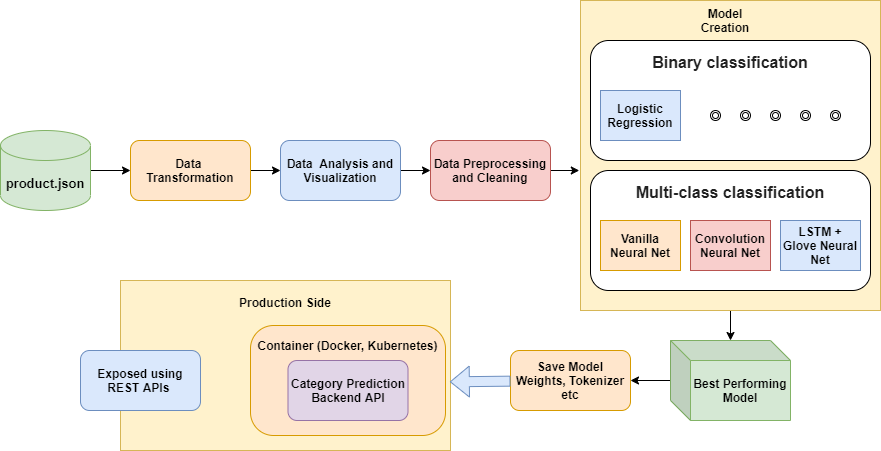

I have followed the CRISP-DM Process:

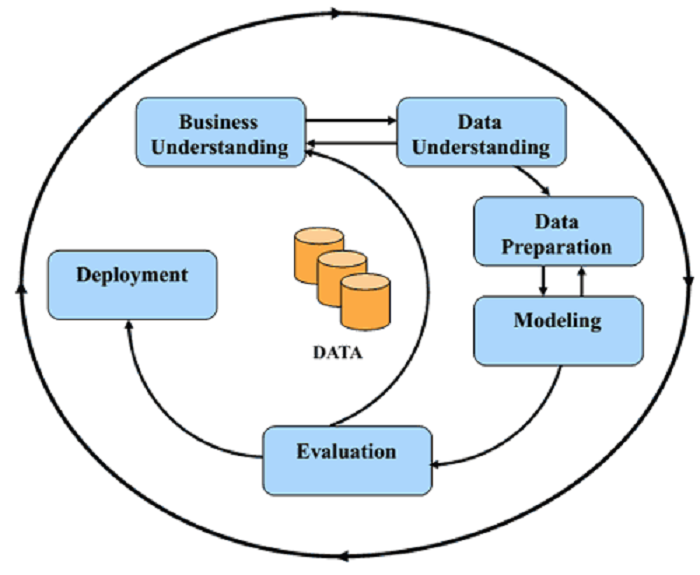

## Import Dataset
The dataset can be found here: https://github.com/BestBuyAPIs/open-data-set

It contains data in the form of three json files : categories.json, products.json and stores.json

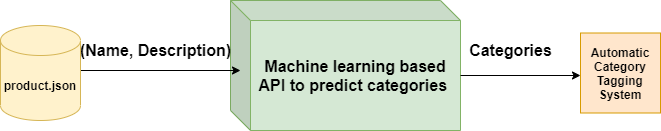

The stores.json contains information like store id, type, name, address, hours etc which is not relevant for this task at this point.
The categories.json list different categories from which our predictions will belong to, but will not be used for our work.
The file used is product.json which contains the product names, description and their categories, from which our model will learn to tag categories to new products.

In [ ]:
f = open('drive/My Drive/datasets/Netflix/products.json')
data = json.load(f) # returns JSON object as a dictionary

In [ ]:
data[10] 

{'category': [{'id': 'abcat0300000', 'name': 'Car Electronics & GPS'},
  {'id': 'pcmcat165900050023', 'name': 'Car Installation Parts & Accessories'},
  {'id': 'pcmcat331600050007', 'name': 'Car Audio Installation Parts'},
  {'id': 'pcmcat165900050031', 'name': 'Deck Installation Parts'},
  {'id': 'pcmcat165900050033', 'name': 'Dash Installation Kits'}],
 'description': 'From our expanded online assortment; compatible with select GM vehicles; plastic material',
 'image': 'http://img.bbystatic.com/BestBuy_US/images/products/3466/346646_rc.jpg',
 'manufacturer': 'Metra',
 'model': '99-4500',
 'name': 'Metra - Radio Dash Multikit for Select GM Vehicles - Black',
 'price': 16.99,
 'shipping': 0,
 'sku': 346646,
 'type': 'HardGood',
 'upc': '086429003273',
 'url': 'http://www.bestbuy.com/site/metra-radio-dash-multikit-for-select-gm-vehicles-black/346646.p?id=1210376657731&skuId=346646CC'}

From the above example we can see **product name : Metra - Radio Dash Multikit for Select GM Vehicles - Black** with **description : From our expanded online assortment; compatible with select GM vehicles; plastic material** belongs to **categories like Car Electronics & GPS, Car Installation Parts & Accessories, Car Audio Installation Parts, Deck Installation Parts and Dash Installation Kits**.

In [ ]:
# creating dataframe with three rows (name,description,categories)
column_names = ['name','description','categories']
df = pd.DataFrame(columns = column_names)

In [ ]:
names,descriptions,categories = [],[],[]
for product in data:
  names.append(product['name'])
  descriptions.append(product['description'])
  productCategories = []
  for cat in product['category']:
    productCategories.append(cat['name'])
  categories.append(productCategories)

In [ ]:
df = pd.DataFrame(list(zip(names,descriptions,categories)) ,columns = column_names)
df

,name,description,categories
0,Duracell - AAA Batteries (4-Pack),Compatible with select electronic devices; AAA...,"[Connected Home & Housewares, Housewares, Hous..."
1,Duracell - AA 1.5V CopperTop Batteries (4-Pack),Long-lasting energy; DURALOCK Power Preserve t...,"[Connected Home & Housewares, Housewares, Hous..."
2,Duracell - AA Batteries (8-Pack),Compatible with select electronic devices; AA ...,"[Connected Home & Housewares, Housewares, Hous..."
3,Energizer - MAX Batteries AA (4-Pack),4-pack AA alkaline batteries; battery tester i...,"[Connected Home & Housewares, Housewares, Hous..."
4,Duracell - C Batteries (4-Pack),Compatible with select electronic devices; C s...,"[Connected Home & Housewares, Housewares, Hous..."
...,...,...,...
51641,Honeywell - True HEPA Replacement Filters for ...,Compatible with select Honeywell air purifier ...,"[Appliances, Appliance Parts & Accessories, Ai..."
51642,Dyson - Hard Floor Wipes for Dyson Hard DC56 V...,Removes dirt and grime from hard floors; cloth...,"[Appliances, Appliance Parts & Accessories, Va..."
51643,Aleratec - Drive Enclosure - Internal - Black,"1 x Total Bay - 1 x 2.5"" Bay","[Computers & Tablets, Computer Accessories & P..."
51644,Amazon - Fire TV Stick,"Streams 1080p content; dual-band, dual-antenna...","[TV & Home Theater, Streaming Media Players, R..."


There are total **51646** products listed in the product.json file.
As each instanse can belong to multiple categories, so these types of problems are known as **multi-label classification problem**, where we have a set of target labels.
If there are multiple categories but each instance is assigned only one, therefore such problems are known as **multi-class classification problem**.

Multi-class problem acknowledge that all the classes are mutually exclusive, but in our case it is not as a product can belong to multiple classes/categories.

In [ ]:
cat = pd.DataFrame(df['categories'].to_list()) # listing the categories seperately
cat.head()

,0,1,2,3,4,5,6
0,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,None,None,None
1,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,None,None,None
2,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,None,None,None
3,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,None,None,None
4,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,None,None,None


In [ ]:
# finding total unique categories/classes from which our prediction will belong too
category_0 = cat[0].unique()
category_1 = cat[1].unique()
category_2 = cat[2].unique()
category_3 = cat[3].unique()
category_4 = cat[4].unique()
category_5 = cat[5].unique()
category_6 = cat[6].unique()
cates = np.concatenate([category_0, category_1, category_2,category_3,category_4,category_5,category_6])
cates = list(dict.fromkeys(cates))
cates = [x for x in cates if x is not None] # remove None
len(cates) # number of unique classes/categories

1802

In [ ]:
cat = pd.concat([cat,pd.DataFrame(columns = list(cates))]) # concatnate categories/classes to original dataframe
cat.fillna(0, inplace = True) # fill with zero
cat.head()

,0,1,2,3,4,5,6,2-Channel Amps,2-Way Speakers,2-in-1s,3-Way Speakers,"3.5"" Car Speakers",360 Degree Cameras,3D Blu-ray Players,3D Glasses,3D Printer Filament,3D Printers,3D Printers & Filament,3D Printing Accessories,3D Printing Accessories & Scanners,3D Scanners,"4"" Car Speakers","4"" x 10"" Car Speakers","4"" x 6"" Car Speakers",4G LTE Laptops,4K Ultra HD Monitors,4K Ultra HD TVs,"5"" Speakers","5"" x 7"" Car Speakers","5.25"" Car Speakers","6"" x 8"" Car Speakers","6"" x 9"" Car Speakers","6.5"" Car Speakers",8mm Videotapes,A/V Adapters,A/V Cables & Adapters,A/V Cables & Connectors,A/V Component Racks,A/V Component Shelving,A/V Couplers,...,iPad Pro 12.9-inch,iPad Screen Protectors,iPad Stands & Mounts,iPad Stylus Pens,iPad mini 4,"iPad, Tablet & E-Reader Accessories",iPhone,iPhone 5s Cases,iPhone 6 Cases,iPhone 6 Plus Cases,iPhone 6s Cases,iPhone 6s Plus Cases,iPhone Accessories,iPhone Adapters,iPhone Appcessories¿ Products,iPhone Armbands,iPhone Cables,iPhone Car Mounts,iPhone Cases & Clips,iPhone Chargers & Adapters,iPhone Charging Docks,iPhone Headsets,iPhone SE,iPhone Screen Protectors,iPod & MP3 Batteries & Chargers,iPod & MP3 Player Accessories,iPod & MP3 Player Cables & Connectors,iPod & MP3 Player Chargers,iPod & MP3 Player Speakers,iPod Adapters for Aftermarket Decks,iPod and MP3 Players,iPod nano,iPod shuffle,iPod touch,iPod-Ready Decks,iPods,iRobot,iRobot Accessories,iRobot Hard Floor Cleaning Robots,iRobot Vacuum Cleaning Robots
0,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# filling attendence for all the categories/classes
for i in range(7):
  row = 0
  for category in cat[i]:
    if category!= 0:
      cat.loc[row,category] = 1 # loc is label-based, which means that you have to specify rows and columns based on their row and column labels.
    row = row + 1
# iloc is integer position-based, so you have to specify rows and columns by their integer position values (0-based integer position)

In [ ]:
cat.head()

,0,1,2,3,4,5,6,2-Channel Amps,2-Way Speakers,2-in-1s,3-Way Speakers,"3.5"" Car Speakers",360 Degree Cameras,3D Blu-ray Players,3D Glasses,3D Printer Filament,3D Printers,3D Printers & Filament,3D Printing Accessories,3D Printing Accessories & Scanners,3D Scanners,"4"" Car Speakers","4"" x 10"" Car Speakers","4"" x 6"" Car Speakers",4G LTE Laptops,4K Ultra HD Monitors,4K Ultra HD TVs,"5"" Speakers","5"" x 7"" Car Speakers","5.25"" Car Speakers","6"" x 8"" Car Speakers","6"" x 9"" Car Speakers","6.5"" Car Speakers",8mm Videotapes,A/V Adapters,A/V Cables & Adapters,A/V Cables & Connectors,A/V Component Racks,A/V Component Shelving,A/V Couplers,...,iPad Pro 12.9-inch,iPad Screen Protectors,iPad Stands & Mounts,iPad Stylus Pens,iPad mini 4,"iPad, Tablet & E-Reader Accessories",iPhone,iPhone 5s Cases,iPhone 6 Cases,iPhone 6 Plus Cases,iPhone 6s Cases,iPhone 6s Plus Cases,iPhone Accessories,iPhone Adapters,iPhone Appcessories¿ Products,iPhone Armbands,iPhone Cables,iPhone Car Mounts,iPhone Cases & Clips,iPhone Chargers & Adapters,iPhone Charging Docks,iPhone Headsets,iPhone SE,iPhone Screen Protectors,iPod & MP3 Batteries & Chargers,iPod & MP3 Player Accessories,iPod & MP3 Player Cables & Connectors,iPod & MP3 Player Chargers,iPod & MP3 Player Speakers,iPod Adapters for Aftermarket Decks,iPod and MP3 Players,iPod nano,iPod shuffle,iPod touch,iPod-Ready Decks,iPods,iRobot,iRobot Accessories,iRobot Hard Floor Cleaning Robots,iRobot Vacuum Cleaning Robots
0,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df2 = pd.concat([df['name'],df['description'],cat.loc[:,"2-Channel Amps":]],axis=1) # creating new dataframe which contains name of product,description and categories it belong to
df2.head()

,name,description,2-Channel Amps,2-Way Speakers,2-in-1s,3-Way Speakers,"3.5"" Car Speakers",360 Degree Cameras,3D Blu-ray Players,3D Glasses,3D Printer Filament,3D Printers,3D Printers & Filament,3D Printing Accessories,3D Printing Accessories & Scanners,3D Scanners,"4"" Car Speakers","4"" x 10"" Car Speakers","4"" x 6"" Car Speakers",4G LTE Laptops,4K Ultra HD Monitors,4K Ultra HD TVs,"5"" Speakers","5"" x 7"" Car Speakers","5.25"" Car Speakers","6"" x 8"" Car Speakers","6"" x 9"" Car Speakers","6.5"" Car Speakers",8mm Videotapes,A/V Adapters,A/V Cables & Adapters,A/V Cables & Connectors,A/V Component Racks,A/V Component Shelving,A/V Couplers,A/V Splitters,A/V Surge Protectors & Power,A/V Switchers,AT&T,AT&T Hotspots,...,iPad Pro 12.9-inch,iPad Screen Protectors,iPad Stands & Mounts,iPad Stylus Pens,iPad mini 4,"iPad, Tablet & E-Reader Accessories",iPhone,iPhone 5s Cases,iPhone 6 Cases,iPhone 6 Plus Cases,iPhone 6s Cases,iPhone 6s Plus Cases,iPhone Accessories,iPhone Adapters,iPhone Appcessories¿ Products,iPhone Armbands,iPhone Cables,iPhone Car Mounts,iPhone Cases & Clips,iPhone Chargers & Adapters,iPhone Charging Docks,iPhone Headsets,iPhone SE,iPhone Screen Protectors,iPod & MP3 Batteries & Chargers,iPod & MP3 Player Accessories,iPod & MP3 Player Cables & Connectors,iPod & MP3 Player Chargers,iPod & MP3 Player Speakers,iPod Adapters for Aftermarket Decks,iPod and MP3 Players,iPod nano,iPod shuffle,iPod touch,iPod-Ready Decks,iPods,iRobot,iRobot Accessories,iRobot Hard Floor Cleaning Robots,iRobot Vacuum Cleaning Robots
0,Duracell - AAA Batteries (4-Pack),Compatible with select electronic devices; AAA...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Duracell - AA 1.5V CopperTop Batteries (4-Pack),Long-lasting energy; DURALOCK Power Preserve t...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Duracell - AA Batteries (8-Pack),Compatible with select electronic devices; AA ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Energizer - MAX Batteries AA (4-Pack),4-pack AA alkaline batteries; battery tester i...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Duracell - C Batteries (4-Pack),Compatible with select electronic devices; C s...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df2.shape

(51646, 1804)

There are **51646** product with **1802** classes/category.

## Data Analysis

Count of occurance of each category, to check most frequently occuring categories.

In [ ]:
bar_plot = pd.DataFrame()
bar_plot['category'] = df2.columns[2:] # column name, which are categories
bar_plot['count'] = df2.iloc[:,2:].sum().values
bar_plot.sort_values(['count'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
bar_plot.head() # Top 5 most occuring categories

,category,count
0,Appliances,9317
1,Cell Phones,6905
2,Cell Phone Accessories,6176
3,Computers & Tablets,6088
4,Video Games,5837


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


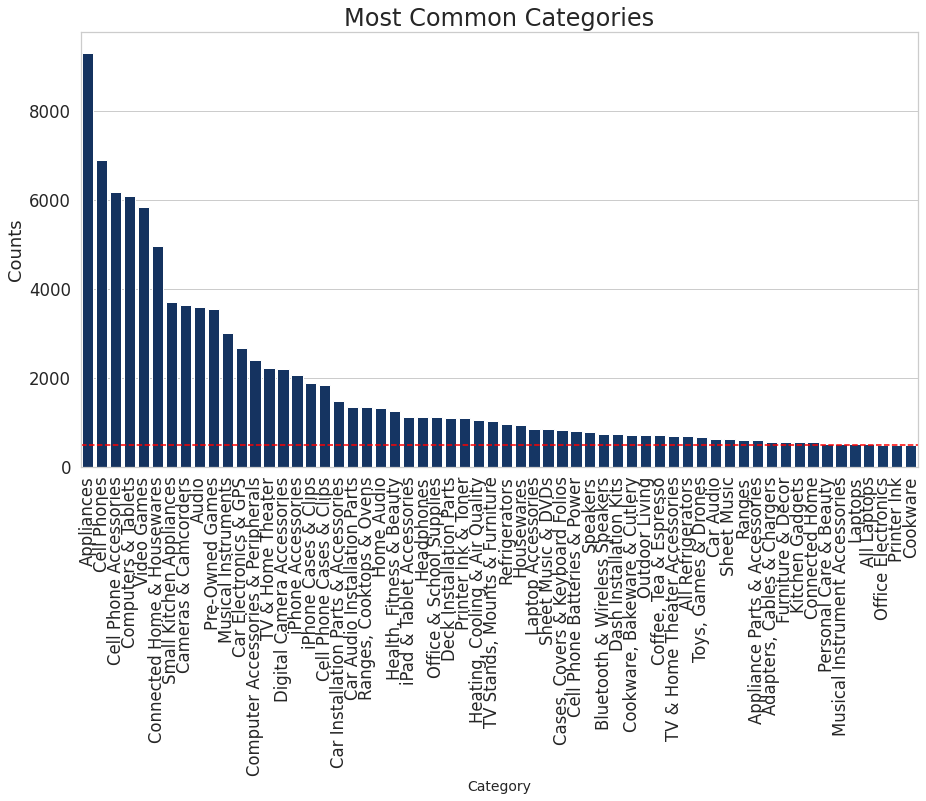

In [ ]:
threshold = 500 # A threshold is a value below which all those classes whose count is less than threshold will be treated as 'other' category

plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 

pal = sns.color_palette("Blues_r", len(bar_plot))
rank = bar_plot['count'].argsort().argsort()  

sns.barplot(bar_plot['category'][:60], bar_plot['count'][:60], palette=np.array(pal[::-1])[rank]) # include first few values
plt.axhline(threshold, ls='--', c='red')
plt.title("Most Common Categories", fontsize=24)
plt.ylabel('Counts', fontsize=18)
plt.xlabel('Category', fontsize=14)
plt.xticks(rotation='vertical')
# plt.xticks(color='w') # comment this to view labels
plt.show()

In [ ]:
threshold = 100 # taking a lower threshold so can include higher number of classes/categories in consideration, can change this to even lower if want more classes

warnings.filterwarnings('ignore')

main_categories = pd.DataFrame()
main_categories = bar_plot[bar_plot['count']>threshold]
categories = main_categories['category'].values
categories = np.append(categories,'Others')
not_category = []
df2['Others'] = 0

for i in df2.columns[2:]:
    if i not in categories:
        df2['Others'][df2[i] == 1] = 1
        not_category.append(i)

df2.drop(not_category, axis=1, inplace=True)

In [ ]:
df2.shape

(51646, 271)

In [ ]:
df2

,name,description,3D Printer Filament,A/V Cables & Connectors,Action Camcorder Accessories,Action Camcorder Mounts,Activity Trackers & Pedometers,"Adapters, Cables & Chargers",Air Conditioners,Air Purifier Filters & Parts,Air Purifiers,All Cell Phones with Plans,All Desktops,All Flat-Panel TVs,All Headphones,All Laptops,All Memory Cards,All Microwaves,All Point & Shoot Cameras,All Printers,All Refrigerators,All TV Stands,All Tablets,All Unlocked Cell Phones,Amps & Effects,Antennas & Adapters,Apple Watch,Apple Watch Accessories,Apple Watch Bands & Straps,Appliance Parts & Accessories,Appliances,Audio,Bakeware,Best Buy Gift Cards,Binoculars,"Binoculars, Telescopes & Optics",Blenders,Blenders & Juicers,Bluetooth & Wireless Speakers,Bookshelf Speakers,...,TV Stands,"TV Stands, Mounts & Furniture","TV, Movie & Character Toys",TVs,Tablets,Tea Kettles,Telephone Accessories,Telephones & Communication,Toasters,Toner,Toys to Life,"Toys, Games & Drones",Tripods & Monopods,USB Cables & Hubs,USB Flash Drives,Universal Camera Bags & Cases,Unlocked Cell Phones,Vacuum & Floor Care Accessories,Vacuum Cleaners & Floor Care,Video Game Accessories,Video Games,Wall Art,Wall Chargers & Power Adapters,Wall Mount Range Hoods,Wall Ovens,Washers & Dryers,Washing Machines,Wearable Technology,Wii,Xbox 360,Xbox 360 Games,Xbox One,Xbox One Games,iPad & Tablet Accessories,iPhone 6s Cases,iPhone 6s Plus Cases,iPhone Accessories,iPhone Cases & Clips,iPod & MP3 Player Accessories,Others
0,Duracell - AAA Batteries (4-Pack),Compatible with select electronic devices; AAA...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Duracell - AA 1.5V CopperTop Batteries (4-Pack),Long-lasting energy; DURALOCK Power Preserve t...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Duracell - AA Batteries (8-Pack),Compatible with select electronic devices; AA ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Energizer - MAX Batteries AA (4-Pack),4-pack AA alkaline batteries; battery tester i...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Duracell - C Batteries (4-Pack),Compatible with select electronic devices; C s...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51641,Honeywell - True HEPA Replacement Filters for ...,Compatible with select Honeywell air purifier ...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51642,Dyson - Hard Floor Wipes for Dyson Hard DC56 V...,Removes dirt and grime from hard floors; cloth...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
51643,Aleratec - Drive Enclosure - Internal - Black,"1 x Total Bay - 1 x 2.5"" Bay",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51644,Amazon - Fire TV Stick,"Streams 1080p content; dual-band, dual-antenna...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,

In [ ]:
most_common_cat = pd.DataFrame()
most_common_cat['category'] = df2.columns[2:]
most_common_cat['count'] = df2.iloc[:,2:].sum().values
most_common_cat.sort_values(['count'], inplace=True, ascending=False)
most_common_cat.reset_index(inplace=True, drop=True)
most_common_cat.head()

,category,count
0,Others,22030
1,Appliances,9317
2,Cell Phones,6905
3,Cell Phone Accessories,6176
4,Computers & Tablets,6088


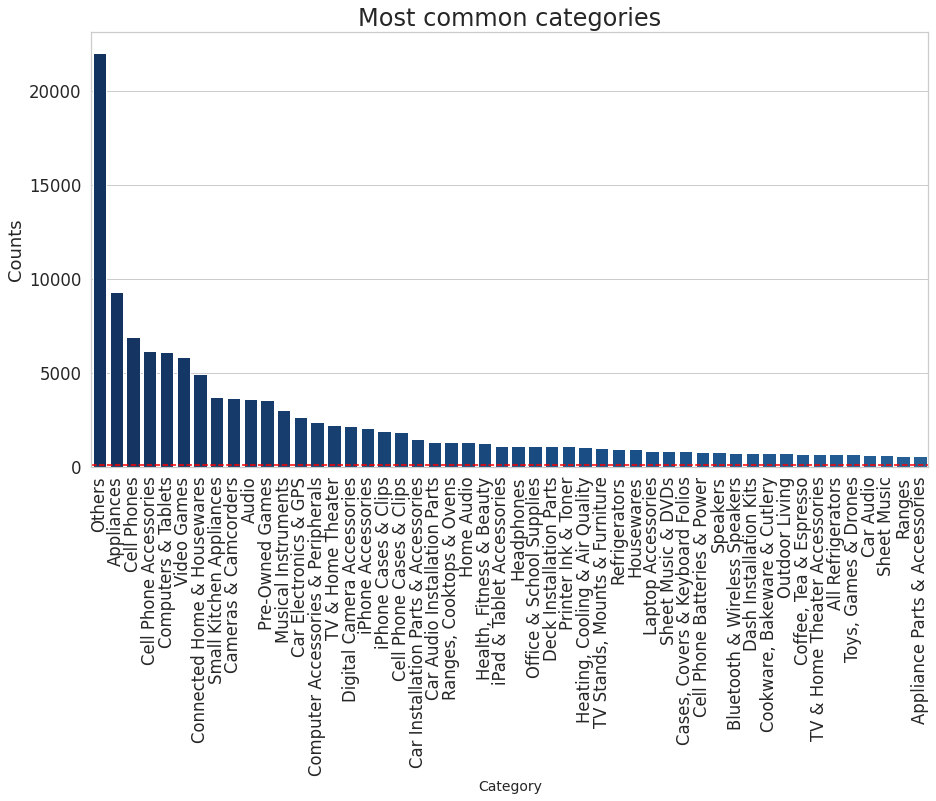

In [ ]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 

pal = sns.color_palette("Blues_r", len(most_common_cat))
rank = most_common_cat['count'].argsort().argsort()  

sns.barplot(most_common_cat['category'][:50], most_common_cat['count'][:50], palette=np.array(pal[::-1])[rank])
plt.axhline(threshold, ls='--', c='red')
plt.title("Most common categories", fontsize=24)
plt.ylabel('Counts', fontsize=18)
plt.xlabel('Category', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
rowSums = df2.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()

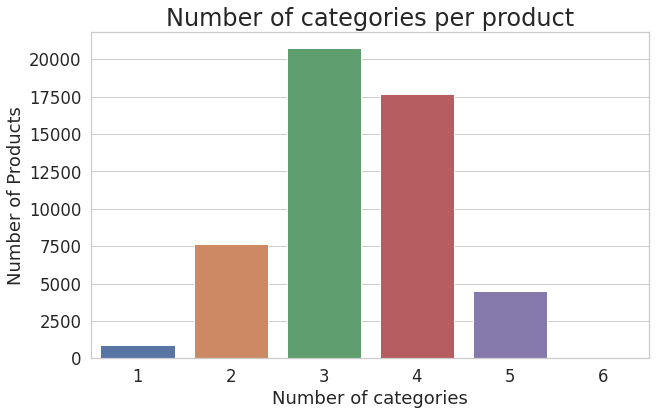

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 
plt.figure(figsize=(10,6))

sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Number of categories per product", fontsize=24)
plt.ylabel('Number of Products', fontsize=18)
plt.xlabel('Number of categories', fontsize=18)

plt.show()

In [ ]:
boxplot = df2.copy()
boxplot['len'] = df2.description.apply(lambda x: len(x)) # length of descriptions

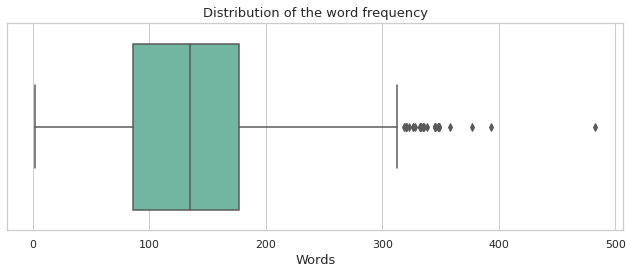

In [ ]:
sns.set(style="whitegrid",rc={"font.size":13,"axes.labelsize":13})
plt.figure(figsize=(9, 4))

ax = sns.boxplot(x='len', data=boxplot, orient="h", palette="Set2")
plt.ylabel('')
plt.xlabel('Words')
plt.title("Distribution of the word frequency", fontsize=13)
plt.tight_layout(h_pad=3)

We can observe that most description's length range from 100 too 200 but there are few outliers till 480.

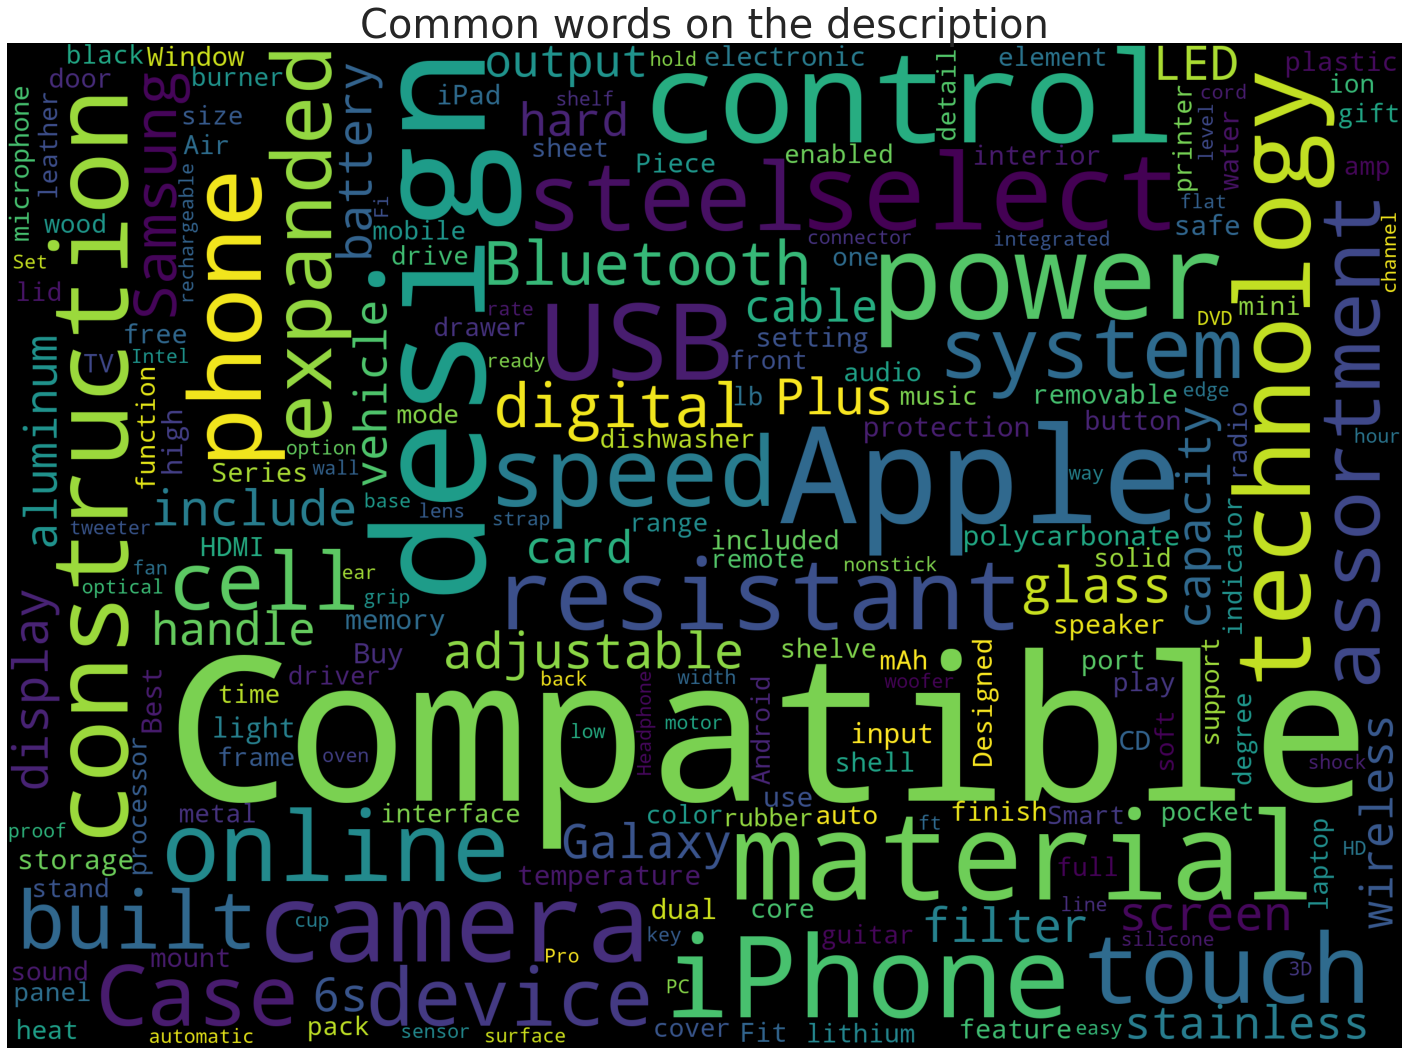

In [ ]:
# Visualizing the main context/keywords of the description of products, to better understand the nature of data
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize=(25,25))
text = df2.description.values
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='black',
                  collocations=False,
                  width=2500,
                  height=1800
                  ).generate(" ".join(text))
plt.axis('off')
plt.title("Common words on the description",fontsize=40)
plt.imshow(cloud)

In [ ]:
# Utility function for data cleaning, natural language processing concepts

def decontract(sentence):
    sentence = str(sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence

def cleanPunc(sentence): 
    sentence = str(sentence)
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence):
    sentence = str(sentence)
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', '', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def removeStopWords(sentence):
    sentence = str(sentence)
    global re_stop_words
    return re_stop_words.sub("", sentence)

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

re_stop_words = re.compile(r"\b(" + "|".join(stopwords) + ")\\W", re.I)

stemmer = SnowballStemmer("english")
def stemming(sentence):
    sentence = str(sentence)
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [ ]:
# Applying data cleaning on description to ignore irrelevant words
df2['description'] = df2['description'].str.lower()
df2['description'] = df2['description'].apply(decontract)
df2['description'] = df2['description'].apply(cleanPunc)
df2['description'] = df2['description'].apply(keepAlpha)
df2['description'] = df2['description'].apply(removeStopWords)
df2['description'] = df2['description'].apply(stemming)

In [ ]:
df2.head()

,name,description,3D Printer Filament,A/V Cables & Connectors,Action Camcorder Accessories,Action Camcorder Mounts,Activity Trackers & Pedometers,"Adapters, Cables & Chargers",Air Conditioners,Air Purifier Filters & Parts,Air Purifiers,All Cell Phones with Plans,All Desktops,All Flat-Panel TVs,All Headphones,All Laptops,All Memory Cards,All Microwaves,All Point & Shoot Cameras,All Printers,All Refrigerators,All TV Stands,All Tablets,All Unlocked Cell Phones,Amps & Effects,Antennas & Adapters,Apple Watch,Apple Watch Accessories,Apple Watch Bands & Straps,Appliance Parts & Accessories,Appliances,Audio,Bakeware,Best Buy Gift Cards,Binoculars,"Binoculars, Telescopes & Optics",Blenders,Blenders & Juicers,Bluetooth & Wireless Speakers,Bookshelf Speakers,...,TV Stands,"TV Stands, Mounts & Furniture","TV, Movie & Character Toys",TVs,Tablets,Tea Kettles,Telephone Accessories,Telephones & Communication,Toasters,Toner,Toys to Life,"Toys, Games & Drones",Tripods & Monopods,USB Cables & Hubs,USB Flash Drives,Universal Camera Bags & Cases,Unlocked Cell Phones,Vacuum & Floor Care Accessories,Vacuum Cleaners & Floor Care,Video Game Accessories,Video Games,Wall Art,Wall Chargers & Power Adapters,Wall Mount Range Hoods,Wall Ovens,Washers & Dryers,Washing Machines,Wearable Technology,Wii,Xbox 360,Xbox 360 Games,Xbox One,Xbox One Games,iPad & Tablet Accessories,iPhone 6s Cases,iPhone 6s Plus Cases,iPhone Accessories,iPhone Cases & Clips,iPod & MP3 Player Accessories,Others
0,Duracell - AAA Batteries (4-Pack),compat select electron devic aaa size duralock...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Duracell - AA 1.5V CopperTop Batteries (4-Pack),longlast energi duralock power preserv technol...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Duracell - AA Batteries (8-Pack),compat select electron devic aa size duralock ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Energizer - MAX Batteries AA (4-Pack),pack aa alkalin batteri batteri tester includ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Duracell - C Batteries (4-Pack),compat select electron devic c size duralock p...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Applying data cleaning on product name to ignore irrelevant words
df2['name'] = df2['name'].str.lower()
df2['name'] = df2['name'].apply(decontract)
df2['name'] = df2['name'].apply(cleanPunc)
df2['name'] = df2['name'].apply(keepAlpha)
df2['name'] = df2['name'].apply(removeStopWords)
df2['name'] = df2['name'].apply(stemming)

In [ ]:
# creating new column information which is concatenation of product name and description, which stores overall context about any product
df2["information"] = df2["name"] + df2["description"]
df2.head()

,name,description,3D Printer Filament,A/V Cables & Connectors,Action Camcorder Accessories,Action Camcorder Mounts,Activity Trackers & Pedometers,"Adapters, Cables & Chargers",Air Conditioners,Air Purifier Filters & Parts,Air Purifiers,All Cell Phones with Plans,All Desktops,All Flat-Panel TVs,All Headphones,All Laptops,All Memory Cards,All Microwaves,All Point & Shoot Cameras,All Printers,All Refrigerators,All TV Stands,All Tablets,All Unlocked Cell Phones,Amps & Effects,Antennas & Adapters,Apple Watch,Apple Watch Accessories,Apple Watch Bands & Straps,Appliance Parts & Accessories,Appliances,Audio,Bakeware,Best Buy Gift Cards,Binoculars,"Binoculars, Telescopes & Optics",Blenders,Blenders & Juicers,Bluetooth & Wireless Speakers,Bookshelf Speakers,...,"TV Stands, Mounts & Furniture","TV, Movie & Character Toys",TVs,Tablets,Tea Kettles,Telephone Accessories,Telephones & Communication,Toasters,Toner,Toys to Life,"Toys, Games & Drones",Tripods & Monopods,USB Cables & Hubs,USB Flash Drives,Universal Camera Bags & Cases,Unlocked Cell Phones,Vacuum & Floor Care Accessories,Vacuum Cleaners & Floor Care,Video Game Accessories,Video Games,Wall Art,Wall Chargers & Power Adapters,Wall Mount Range Hoods,Wall Ovens,Washers & Dryers,Washing Machines,Wearable Technology,Wii,Xbox 360,Xbox 360 Games,Xbox One,Xbox One Games,iPad & Tablet Accessories,iPhone 6s Cases,iPhone 6s Plus Cases,iPhone Accessories,iPhone Cases & Clips,iPod & MP3 Player Accessories,Others,information
0,duracel aaa batteri pack,compat select electron devic aaa size duralock...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,duracel aaa batteri packcompat select electron...
1,duracel aa v coppertop batteri pack,longlast energi duralock power preserv technol...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,duracel aa v coppertop batteri packlonglast en...
2,duracel aa batteri pack,compat select electron devic aa size duralock ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,duracel aa batteri packcompat select electron ...
3,energ max batteri aa pack,pack aa alkalin batteri batteri tester includ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,energ max batteri aa packpack aa alkalin batte...
4,duracel c batteri pack,compat select electron devic c size duralock p...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,duracel c batteri packcompat select electron d...


## Model Creation

Splitting the data into train/test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df2['information'], 
                                                    df2[df2.columns[2:-1]], 
                                                    test_size=0.3, 
                                                    random_state=0, 
                                                    shuffle=True)

In [ ]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2') # Using a tf-idf weighting scheme rather than normal boolean weights for better performance
vectorizer.fit(X_train) # Reference : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
print("X_train shape : ",X_train.shape)
print("X_test shape : ",X_test.shape)

X_train shape :  (36152, 535768)
X_test shape :  (15494, 535768)


To solve multi-label problems, we mainly have approaches:


1.   **Binary classification** :  This strategy divides the problem into several independent binary classification tasks. It resembles the one-vs-rest method, but each classifier deals with a single label, which means the algorithm assumes they are mutually exclusive.
2.  **Multi-class classification** : The labels are combined into one big binary classifier called powerset. For instance, having the targets A, B, and C, with 0 or 1 as outputs, we have A B C -> [0 1 0], while the binary classification transformation treats it as A B C -> [0] [1] [0].

We will first use the Binary classification technique.


In [ ]:
LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))]) 
# one-vs-all, this strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed), one advantage of this approach is its interpretability. Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier. This is the most commonly used strategy for multiclass classification and is a fair default choice.
# Reference : https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

# sag : Algorithm to use in the optimization problem, ‘saga’ also supports ‘elasticnet’ penalty  Reference : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# n_jobs : The number of jobs to use for the computation: the n_classes one-vs-rest problems are computed in parallel. Reference : https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html
# clf : name given to the Pipeline

accuracy = 0
auc = 0
modelNumber = 1
for category in df2.columns[2:-1]:    
    LR_pipeline.fit(X_train, y_train[category]) # Training logistic regression model on train data
    prediction = LR_pipeline.predict(X_test)    # calculating predictions
    acc = accuracy_score(y_test[category], prediction)
    au = roc_auc_score(y_test[category],prediction)
    accuracy = accuracy + acc
    auc = auc + au
    print('CATEGORY => {} '.format(category),'AUC ROC score => {}'.format(au)," Accuracy => {}".format(acc))
    filename = str(modelNumber)+"_model.sav"
    joblib.dump(LR_pipeline, filename)          # saving individual classifiers for later use
    modelNumber += 1
print("-------------------------------------------------------------------------------------------------------------------------------")
print('Test averaged Accuracy => {}'.format(accuracy/len(df2.columns[2:-1])))
print('Test averaged AUC ROC Score => {}'.format(auc/len(df2.columns[2:-1])))

CATEGORY => 3D Printer Filament  AUC ROC score => 0.8866342391421839  Accuracy => 0.9988382599716019
CATEGORY => A/V Cables & Connectors  AUC ROC score => 0.6748894557701878  Accuracy => 0.9936749709564993
CATEGORY => Action Camcorder Accessories  AUC ROC score => 0.6322557027478436  Accuracy => 0.9965793210274945
CATEGORY => Action Camcorder Mounts  AUC ROC score => 0.5475866893482736  Accuracy => 0.9974828966051374
CATEGORY => Activity Trackers & Pedometers  AUC ROC score => 0.6964285714285714  Accuracy => 0.9978056021685814
CATEGORY => Adapters, Cables & Chargers  AUC ROC score => 0.7692158954043504  Accuracy => 0.9941912998580096
CATEGORY => Air Conditioners  AUC ROC score => 0.8780164243110107  Accuracy => 0.9992900477604234
CATEGORY => Air Purifier Filters & Parts  AUC ROC score => 0.5434782608695652  Accuracy => 0.9986446366335355
CATEGORY => Air Purifiers  AUC ROC score => 0.6617647058823529  Accuracy => 0.998515554408158
CATEGORY => All Cell Phones with Plans  AUC ROC score =>

In [ ]:
# Api for category prediction
def categoryPrediction(name,description):
  # performing necessary data cleaning operations od product name and description
  name = name.lower()
  name = decontract(name)
  name = cleanPunc(name)
  name = keepAlpha(name)
  name = removeStopWords(name)
  name = stemming(name)

  description = description.lower()
  description = decontract(description)
  description = cleanPunc(description)
  description = keepAlpha(description)
  description = removeStopWords(description)
  description = stemming(description)

  information = name + description  # creating information text
  X_api = vectorizer.transform([information]) # transforming using already trained vectorizing transformer

  # LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])
  accuracy = 0
  modelNumber = 1
  for category in df2.columns[2:-1]:
    # LR_pipeline.fit(X_train, y_train[category])
    filename = str(modelNumber)+"_model.sav"
    modelNumber += 1
    LR_pipeline = joblib.load(filename) # loading already saved model

    # calculating test accuracy
    prediction = LR_pipeline.predict(X_api)
    if prediction==1:
      print('CATEGORY {}'.format(category)) # if models predicts true print that category

In [ ]:
name = "Samsung - Galaxy S7 32GB - Black Onyx (Sprint)"
description = "Qualcomm Snapdragon 820 MSM8996 2.2GHz quad-core processorAndroid 6.0 Marshmallow operating system4G mobile hotspot capability with support for up to 10 devicesWiFi Capable 802.11 a/b/g/n/ac5.1\" WQHD touch-screen displayBluetooth 4.2"
categoryPrediction(name,description)

CATEGORY Cell Phones


In [ ]:
name = "Duracell - AAA Batteries (4-Pack)"
description = "Compatible with select electronic devices; AAA size; DURALOCK Power Preserve technology; 4-pack"
categoryPrediction(name,description)

CATEGORY Connected Home & Housewares
CATEGORY Housewares
CATEGORY Others


In [ ]:
# Test for API
name = "Motorola - Moto 360 2nd Generation Men's Smartwatch 42mm Stainless Steel - Gold Stainless Steel"
description = "Fits most wrist sizesCompatible with most Apple&#174; iOS and Android cell phones22mm stainless steel bandWater-resistant designAt-a-glance notifications"
categoryPrediction(name,description)

CATEGORY Cell Phone Accessories
CATEGORY Cell Phones
CATEGORY Smartwatches & Accessories
CATEGORY Others


Other models worth trying are Naive Bayes, SVC, Random Forest.

# Deep Learning Based Models

Follows the Multi-class classification based model.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
df2['information']

0        duracel aaa batteri packcompat select electron...
1        duracel aa v coppertop batteri packlonglast en...
2        duracel aa batteri packcompat select electron ...
3        energ max batteri aa packpack aa alkalin batte...
4        duracel c batteri packcompat select electron d...
                               ...                        
51641    honeywel true hepa replac filter select honeyw...
51642    dyson hard floor wipe dyson hard dc vacuum pac...
51643    aleratec drive enclosur intern blackx total ba...
51644    amazon fire tv stickstream p content dualband ...
51645    proctor silex slice toaster oven whiteproctor ...
Name: information, Length: 51646, dtype: object

In [ ]:
tokenizer = Tokenizer(num_words=5000, lower=True) # lower : boolean. Whether to convert the texts to lowercase. , num_words : the maximum number of words to keep, based on word frequency.
tokenizer.fit_on_texts(df2['information']) # encoding words of information to integers, Updates internal vocabulary based on a list of sequences.
sequences = tokenizer.texts_to_sequences(df2['information'])
x = pad_sequences(sequences, maxlen=500) # provide tagging to make each sequence of length 500

In [ ]:
x.shape

(51646, 500)

In [ ]:
# Splitting dataset in train/test set
X_train, X_test, y_train, y_test = train_test_split(x, df2[df2.columns[2:-1]], 
                                                    test_size=0.3, 
                                                    random_state=0)

In [ ]:
most_common_cat['class_weight'] = len(most_common_cat) / most_common_cat['count']
class_weight = {}    
most_common_cat.head()

,category,count,class_weight
0,Others,22030,0.012211
1,Appliances,9317,0.028872
2,Cell Phones,6905,0.038957
3,Cell Phone Accessories,6176,0.043556
4,Computers & Tablets,6088,0.044185


In [ ]:
categories # categories in which our results will belong to

array(['Appliances', 'Cell Phones', 'Cell Phone Accessories',
       'Computers & Tablets', 'Video Games',
       'Connected Home & Housewares', 'Small Kitchen Appliances',
       'Cameras & Camcorders', 'Audio', 'Pre-Owned Games',
       'Musical Instruments', 'Car Electronics & GPS',
       'Computer Accessories & Peripherals', 'TV & Home Theater',
       'Digital Camera Accessories', 'iPhone Accessories',
       'iPhone Cases & Clips', 'Cell Phone Cases & Clips',
       'Car Installation Parts & Accessories',
       'Car Audio Installation Parts', 'Ranges, Cooktops & Ovens',
       'Home Audio', 'Health, Fitness & Beauty',
       'iPad & Tablet Accessories', 'Headphones',
       'Office & School Supplies', 'Deck Installation Parts',
       'Printer Ink & Toner', 'Heating, Cooling & Air Quality',
       'TV Stands, Mounts & Furniture', 'Refrigerators', 'Housewares',
       'Laptop Accessories', 'Sheet Music & DVDs',
       'Cases, Covers & Keyboard Folios', 'Cell Phone Batteries & Po

In [ ]:
num_classes = y_train.shape[1]
max_words = len(tokenizer.word_index) + 1
maxlen = 500

In [ ]:
num_classes # number of categories/classes

269

In [ ]:
max_words # max words/ total vocab + 1 

37031

In [ ]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPool1D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf

model = Sequential()
model.add(Embedding(max_words, 300, input_length=maxlen)) # Turns positive integers (indexes) into dense vectors of fixed size, input_dim = 500, output_dim = 300
#model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer=Adam(0.015), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
callbacks = [
    ReduceLROnPlateau(), # Reduce learning rate when a metric has stopped improving
    #EarlyStopping(patience=10),
    ModelCheckpoint(filepath='model-neural-net.h5', save_best_only=True)
]

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          11109300  
_________________________________________________________________
dense (Dense)                (None, 500, 300)          90300     
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 269)               80969     
Total params: 11,280,569
Trainable params: 11,280,569
Non-trainable params: 0
_________________________________________________________________


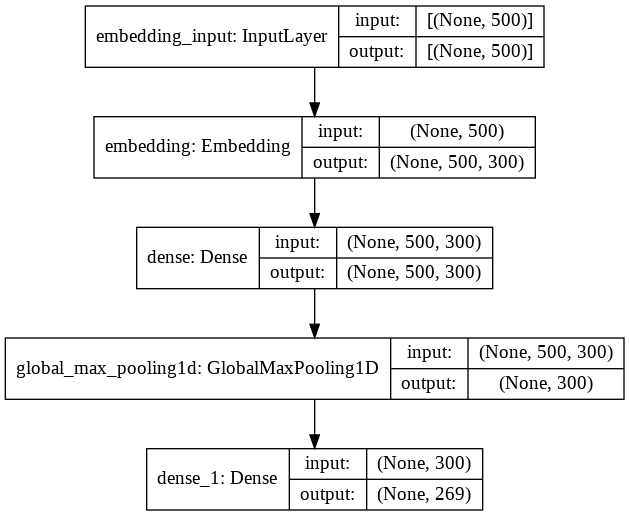

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_nn_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.3,
                    callbacks=callbacks)

Epoch 1/30
791/791 [==============================] - 24s 26ms/step - loss: 0.0322 - auc: 0.9389 - val_loss: 0.0232 - val_auc: 0.9646
Epoch 2/30
791/791 [==============================] - 20s 26ms/step - loss: 0.0198 - auc: 0.9697 - val_loss: 0.0189 - val_auc: 0.9723
Epoch 3/30
791/791 [==============================] - 20s 26ms/step - loss: 0.0159 - auc: 0.9788 - val_loss: 0.0198 - val_auc: 0.9740
Epoch 4/30
791/791 [==============================] - 20s 26ms/step - loss: 0.0200 - auc: 0.9723 - val_loss: 0.0198 - val_auc: 0.9733
Epoch 5/30
791/791 [==============================] - 20s 26ms/step - loss: 0.0180 - auc: 0.9773 - val_loss: 0.0178 - val_auc: 0.9760
Epoch 6/30
791/791 [==============================] - 20s 26ms/step - loss: 0.0160 - auc: 0.9821 - val_loss: 0.0185 - val_auc: 0.9768
Epoch 7/30
791/791 [==============================] - 20s 26ms/step - loss: 0.0195 - auc: 0.9762 - val_loss: 0.0230 - val_auc: 0.9683
Epoch 8/30
791/791 [==============================] - 20s 25ms

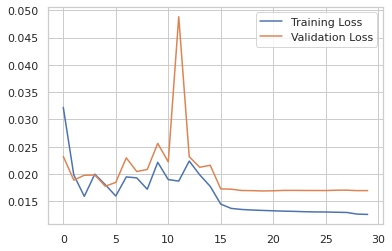

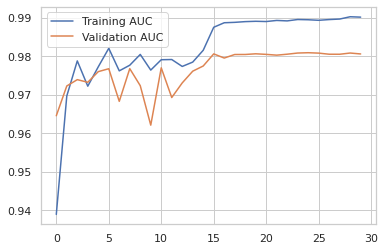

In [ ]:
# Plotting losses wrt epochs(time)
plt.plot(history.history["loss"], label="Training Loss") 
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
# Plotting accuracy wrt epochs(time)
plt.plot(history.history["auc"], label="Training AUC")
plt.plot(history.history["val_auc"], label="Validation AUC")
plt.legend()
plt.show()

In [ ]:
metrics = model.evaluate(X_test, y_test)
print("{}: {}".format(model.metrics_names[1], metrics[1]))

485/485 [==============================] - 4s 8ms/step - loss: 0.0174 - auc: 0.9802
auc: 0.9802485108375549


In [ ]:
classes = [col for col in df2.columns]
classes = classes[2:-1]
classes

['3D Printer Filament',
 'A/V Cables & Connectors',
 'Action Camcorder Accessories',
 'Action Camcorder Mounts',
 'Activity Trackers & Pedometers',
 'Adapters, Cables & Chargers',
 'Air Conditioners',
 'Air Purifier Filters & Parts',
 'Air Purifiers',
 'All Cell Phones with Plans',
 'All Desktops',
 'All Flat-Panel TVs',
 'All Headphones',
 'All Laptops',
 'All Memory Cards',
 'All Microwaves',
 'All Point & Shoot Cameras',
 'All Printers',
 'All Refrigerators',
 'All TV Stands',
 'All Tablets',
 'All Unlocked Cell Phones',
 'Amps & Effects',
 'Antennas & Adapters',
 'Apple Watch',
 'Apple Watch Accessories',
 'Apple Watch Bands & Straps',
 'Appliance Parts & Accessories',
 'Appliances',
 'Audio',
 'Bakeware',
 'Best Buy Gift Cards',
 'Binoculars',
 'Binoculars, Telescopes & Optics',
 'Blenders',
 'Blenders & Juicers',
 'Bluetooth & Wireless Speakers',
 'Bookshelf Speakers',
 'Built-In Dishwashers',
 'CD & DVD Media Storage',
 'CD Players & Turntables',
 'Cables & Connectors',
 'Camcor

In [ ]:
import operator
# Utility function to get predictions using Neural Net model
def categoryPredictionNN(name,description):
  # Data cleaning process
  name = name.lower()
  name = decontract(name)
  name = cleanPunc(name)
  name = keepAlpha(name)
  name = removeStopWords(name)
  name = stemming(name)

  description = description.lower()
  description = decontract(description)
  description = cleanPunc(description)
  description = keepAlpha(description)
  description = removeStopWords(description)
  description = stemming(description)

  information = name + description
  # necessary data preprocessing steps
  sequences = tokenizer.texts_to_sequences([information])
  x = pad_sequences(sequences, maxlen=500)
  prediction = model.predict(x)
  predScores = [score for pred in prediction for score in pred]
  predDict = {}
  for cla,score in zip(classes,predScores):
    predDict[cla] = score

  return sorted(predDict.items(), key=operator.itemgetter(1),reverse=True)[:10] # return top 10 results

In [ ]:
name = "Motorola - Moto 360 2nd Generation Men's Smartwatch 42mm Stainless Steel - Gold Stainless Steel"
description = "Fits most wrist sizesCompatible with most Apple&#174; iOS and Android cell phones22mm stainless steel bandWater-resistant designAt-a-glance notifications"
prediction = categoryPredictionNN(name,description)
prediction

[('Cell Phones', 0.9414992),
 ('Cell Phone Accessories', 0.91653085),
 ('Others', 0.34871173),
 ('Smartwatches & Accessories', 0.28761464),
 ('Smartwatch Accessories', 0.0661437),
 ('Cell Phone Cases & Clips', 0.035128526),
 ('Smartwatch Bands', 0.019480903),
 ('Computers & Tablets', 0.0057120626),
 ('Wearable Technology', 0.005562118),
 ('Cell Phone Batteries & Power', 0.0033624582)]

In [ ]:
name = "Samsung - Galaxy S7 32GB - Black Onyx (Sprint)"
description = "Qualcomm Snapdragon 820 MSM8996 2.2GHz quad-core processorAndroid 6.0 Marshmallow operating system4G mobile hotspot capability with support for up to 10 devicesWiFi Capable 802.11 a/b/g/n/ac5.1\" WQHD touch-screen displayBluetooth 4.2"
prediction = categoryPredictionNN(name,description)
prediction

[('Cell Phones', 0.9961946),
 ('All Cell Phones with Plans', 0.8658402),
 ('Others', 0.08149166),
 ('All Unlocked Cell Phones', 0.011369805),
 ('Unlocked Cell Phones', 0.008204243),
 ('iPod & MP3 Player Accessories', 0.0018935088),
 ('Cameras & Camcorders', 0.000186831),
 ('Name Brands', 0.0001376268),
 ('Toys, Games & Drones', 5.7011064e-05),
 ('Cell Phone Batteries & Power', 5.1186922e-05)]

In [ ]:
name = "Duracell - AAA Batteries (4-Pack)"
description = "Compatible with select electronic devices; AAA size; DURALOCK Power Preserve technology; 4-pack"
prediction = categoryPredictionNN(name,description)
prediction

[('Others', 0.58975905),
 ('Household Batteries', 0.45791835),
 ('Housewares', 0.42572102),
 ('Connected Home & Housewares', 0.2705805),
 ('Cell Phone Batteries & Power', 0.23732899),
 ('Cell Phone Accessories', 0.12389457),
 ('Cell Phones', 0.10485156),
 ('Computers & Tablets', 0.09228797),
 ('Computer Accessories & Peripherals', 0.08647067),
 ('Portable Chargers/Power Packs', 0.0818246)]

In [ ]:
name = "Keurig - Green Mountain Coffee Organic Ethiopia Yirgacheffe K-Cups (16-Pack)"
description = "Compatible with Keurig single-serve K-Cup and 2.0 coffee brewers; notes of citrus and ginger; 16-pack"
prediction = categoryPredictionNN(name,description)
prediction

[('Appliances', 1.0),
 ('Coffee, Tea & Espresso', 0.99999785),
 ('Small Kitchen Appliances', 0.9999968),
 ('Coffee Pods', 0.45578045),
 ('Coffee Pods & Beans', 0.45359275),
 ('Coffee Makers', 0.37891108),
 ('Others', 0.33263376),
 ('Multi-Cup Coffee Makers', 0.0155124655),
 ('Electric Griddles & Hotplates', 0.0005977321),
 ('Food Preparation Utensils', 4.417213e-05)]

In [ ]:
name = "Kung Fu Panda: Showdown of Legendary Legends - Xbox One"
description = "Jump into an all-out brawl for honor, glory and legend status"
prediction = categoryPredictionNN(name,description)
prediction

[('Video Games', 0.9999708),
 ('Xbox One', 0.9522117),
 ('Xbox One Games', 0.9148641),
 ('Xbox 360', 0.15184803),
 ('Others', 0.06697376),
 ('Xbox 360 Games', 0.03130113),
 ('PlayStation 4', 0.013806573),
 ('Video Game Accessories', 0.013297716),
 ('PC Gaming', 0.008662028),
 ('Computer Accessories & Peripherals', 0.00067955005)]

## Conv Net Model

In [ ]:
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D

model = Sequential()
model.add(Embedding(max_words, 300, input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(300, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D()) # This layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs.
model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

callbacks = [
    ReduceLROnPlateau(),
    ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          11109300  
_________________________________________________________________
dropout (Dropout)            (None, 500, 300)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 498, 300)          270300    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 269)               80969     
_________________________________________________________________
activation (Activation)      (None, 269)              

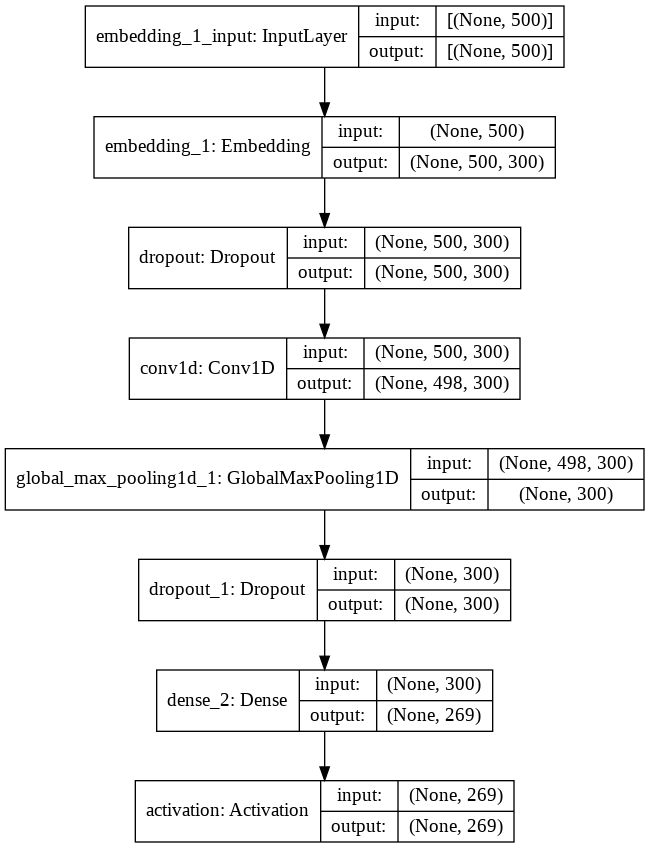

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_cnn_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.3,
                    callbacks=callbacks)

Epoch 1/30
791/791 [==============================] - 66s 49ms/step - loss: 0.0438 - auc_1: 0.9125 - val_loss: 0.0171 - val_auc_1: 0.9890
Epoch 2/30
791/791 [==============================] - 38s 48ms/step - loss: 0.0140 - auc_1: 0.9894 - val_loss: 0.0109 - val_auc_1: 0.9936
Epoch 3/30
791/791 [==============================] - 38s 48ms/step - loss: 0.0097 - auc_1: 0.9939 - val_loss: 0.0090 - val_auc_1: 0.9941
Epoch 4/30
791/791 [==============================] - 38s 48ms/step - loss: 0.0076 - auc_1: 0.9958 - val_loss: 0.0082 - val_auc_1: 0.9938
Epoch 5/30
791/791 [==============================] - 38s 48ms/step - loss: 0.0063 - auc_1: 0.9969 - val_loss: 0.0079 - val_auc_1: 0.9934
Epoch 6/30
791/791 [==============================] - 38s 48ms/step - loss: 0.0054 - auc_1: 0.9976 - val_loss: 0.0079 - val_auc_1: 0.9930
Epoch 7/30
791/791 [==============================] - 38s 48ms/step - loss: 0.0046 - auc_1: 0.9983 - val_loss: 0.0078 - val_auc_1: 0.9918
Epoch 8/30
791/791 [==============

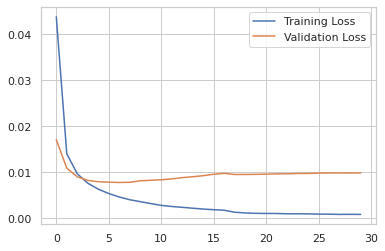

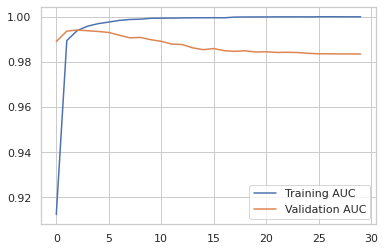

In [ ]:
# Plotting losses wrt epochs(time)
plt.plot(history.history["loss"], label="Training Loss") 
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
# Plotting accuracy wrt epochs(time)
plt.plot(history.history["auc_1"], label="Training AUC")
plt.plot(history.history["val_auc_1"], label="Validation AUC")
plt.legend()
plt.show()

In [ ]:
metrics = model.evaluate(X_test, y_test)
print("{}: {}".format(model.metrics_names[1], metrics[1]))

485/485 [==============================] - 6s 13ms/step - loss: 0.0098 - auc_1: 0.9836
auc_1: 0.9835618734359741


In [ ]:
name = "Motorola - Moto 360 2nd Generation Men's Smartwatch 42mm Stainless Steel - Gold Stainless Steel"
description = "Fits most wrist sizesCompatible with most Apple&#174; iOS and Android cell phones22mm stainless steel bandWater-resistant designAt-a-glance notifications"
prediction = categoryPredictionNN(name,description)
prediction

[('Cell Phones', 0.9999945),
 ('Cell Phone Accessories', 0.99997914),
 ('Others', 0.9999229),
 ('Smartwatches & Accessories', 0.9998704),
 ('Smartwatch Accessories', 0.0002902599),
 ('iPhone Accessories', 8.241499e-05),
 ('Smartwatch Bands', 1.3853268e-05),
 ('Adapters, Cables & Chargers', 8.2079305e-06),
 ('Pre-Owned Games', 7.2256735e-06),
 ('Wall Chargers & Power Adapters', 3.476159e-06)]

In [ ]:
name = "Samsung - Galaxy S7 32GB - Black Onyx (Sprint)"
description = "Qualcomm Snapdragon 820 MSM8996 2.2GHz quad-core processorAndroid 6.0 Marshmallow operating system4G mobile hotspot capability with support for up to 10 devicesWiFi Capable 802.11 a/b/g/n/ac5.1\" WQHD touch-screen displayBluetooth 4.2"
prediction = categoryPredictionNN(name,description)
prediction

[('Cell Phones', 0.99995446),
 ('All Cell Phones with Plans', 0.9997551),
 ('Unlocked Cell Phones', 0.0048751077),
 ('All Unlocked Cell Phones', 0.0009406521),
 ('Others', 0.0009243891),
 ('Memory Cards', 9.0651076e-05),
 ('Name Brands', 2.2462818e-05),
 ('Cell Phone Accessories', 4.764526e-06),
 ('iPhone Accessories', 3.8404423e-06),
 ('Video Games', 2.4172457e-06)]

In [ ]:
name = "Duracell - AAA Batteries (4-Pack)"
description = "Compatible with select electronic devices; AAA size; DURALOCK Power Preserve technology; 4-pack"
prediction = categoryPredictionNN(name,description)
prediction

[('Others', 0.99999225),
 ('Household Batteries', 0.99999094),
 ('Connected Home & Housewares', 0.9999871),
 ('Housewares', 0.9999833),
 ('Household Essentials', 0.00041118963),
 ('Musical Instrument Accessories', 7.030809e-05),
 ('Outdoor Living', 2.5869182e-05),
 ('Patio Furniture & Decor', 2.269643e-05),
 ('Furniture & Decor', 1.2533402e-05),
 ('Home Audio', 8.586917e-06)]

In [ ]:
name = "Keurig - Green Mountain Coffee Organic Ethiopia Yirgacheffe K-Cups (16-Pack)"
description = "Compatible with Keurig single-serve K-Cup and 2.0 coffee brewers; notes of citrus and ginger; 16-pack"
prediction = categoryPredictionNN(name,description)
prediction

[('Appliances', 1.0),
 ('Coffee, Tea & Espresso', 0.99999976),
 ('Small Kitchen Appliances', 0.99998677),
 ('Coffee Pods & Beans', 0.98284125),
 ('Coffee Pods', 0.97692025),
 ('Others', 0.12987375),
 ('Coffee Makers', 9.317827e-05),
 ('Pre-Owned Games', 4.7141268e-05),
 ('Toys, Games & Drones', 7.1472828e-06),
 ('Blenders & Juicers', 2.1098922e-06)]

In [ ]:
name = "Kung Fu Panda: Showdown of Legendary Legends - Xbox One"
description = "Jump into an all-out brawl for honor, glory and legend status"
prediction = categoryPredictionNN(name,description)
prediction

[('Video Games', 1.0),
 ('Xbox One', 0.9999716),
 ('Xbox One Games', 0.9998442),
 ('Others', 0.0008864943),
 ('PlayStation 4', 0.0004631719),
 ('Pre-Owned Games', 0.00024294778),
 ('PS4 Games', 0.00015946868),
 ('Toys to Life', 4.5421897e-05),
 ('Xbox 360', 2.801538e-05),
 ('PC Gaming', 1.3896777e-05)]

## LSTM + Glove Model

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
# Importing glove file
glove_file = open('drive/My Drive/datasets/glove.6B.100d.txt', encoding="utf8") # Reference : https://nlp.stanford.edu/projects/glove/
# GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((max_words, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
from keras.layers import Input
from keras.layers import Flatten, LSTM
from keras.models import Model

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(max_words, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
dropout_embedding_layer = Dropout(0.2)(embedding_layer)
LSTM_Layer_1 = LSTM(300)(dropout_embedding_layer)
dropout_LSTM_Layer_1 =  Dropout(0.2)(LSTM_Layer_1)
dense_layer_1 = Dense(num_classes, activation='sigmoid')(dropout_LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

callbacks = [
    ReduceLROnPlateau(),
    ModelCheckpoint(filepath='model-LSTM.h5', save_best_only=True)
]

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 500, 100)          3703100   
_________________________________________________________________
dropout_4 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               481200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 269)               80969     
Total params: 4,265,269
Trainable params: 562,169
Non-trainable params: 3,703,100
___________________________________________

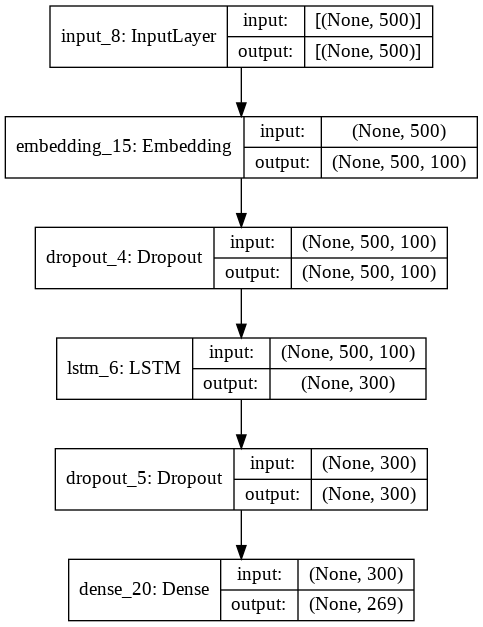

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_LSTM_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train.values,
                    class_weight=class_weight,
                    batch_size=32, 
                    epochs=30, 
                    validation_split=0.3,
                    callbacks=callbacks)

Epoch 1/30
791/791 [==============================] - 132s 163ms/step - loss: 0.0595 - auc_3: 0.8077 - val_loss: 0.0475 - val_auc_3: 0.8666
Epoch 2/30
791/791 [==============================] - 128s 162ms/step - loss: 0.0442 - auc_3: 0.8947 - val_loss: 0.0405 - val_auc_3: 0.9230
Epoch 3/30
791/791 [==============================] - 128s 162ms/step - loss: 0.0374 - auc_3: 0.9354 - val_loss: 0.0330 - val_auc_3: 0.9559
Epoch 4/30
791/791 [==============================] - 127s 161ms/step - loss: 0.0336 - auc_3: 0.9489 - val_loss: 0.0435 - val_auc_3: 0.8997
Epoch 5/30
791/791 [==============================] - 128s 162ms/step - loss: 0.0323 - auc_3: 0.9552 - val_loss: 0.0276 - val_auc_3: 0.9705
Epoch 6/30
791/791 [==============================] - 127s 161ms/step - loss: 0.0271 - auc_3: 0.9700 - val_loss: 0.0244 - val_auc_3: 0.9757
Epoch 7/30
791/791 [==============================] - 128s 162ms/step - loss: 0.0239 - auc_3: 0.9761 - val_loss: 0.0216 - val_auc_3: 0.9816
Epoch 8/30
791/791 [

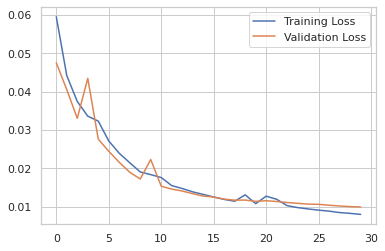

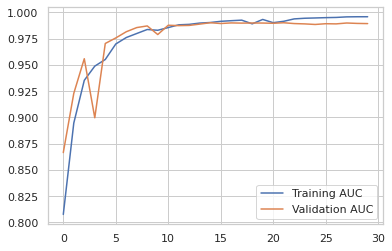

In [ ]:
# Plotting losses wrt epochs(time)
plt.plot(history.history["loss"], label="Training Loss") 
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
# Plotting accuracy wrt epochs(time)
plt.plot(history.history["auc_3"], label="Training AUC")
plt.plot(history.history["val_auc_3"], label="Validation AUC")
plt.legend()
plt.show()

In [ ]:
metrics = model.evaluate(X_test, y_test)
print("{}: {}".format(model.metrics_names[1], metrics[1]))

485/485 [==============================] - 24s 50ms/step - loss: 0.0100 - auc_3: 0.9892
auc_3: 0.9891976118087769


In [ ]:
name = "Motorola - Moto 360 2nd Generation Men's Smartwatch 42mm Stainless Steel - Gold Stainless Steel"
description = "Fits most wrist sizesCompatible with most Apple&#174; iOS and Android cell phones22mm stainless steel bandWater-resistant designAt-a-glance notifications"
prediction = categoryPredictionNN(name,description)
prediction

[('Cell Phones', 0.9937966),
 ('Smartwatches & Accessories', 0.99336255),
 ('Cell Phone Accessories', 0.9900643),
 ('Smartwatch Accessories', 0.5258138),
 ('Others', 0.4321764),
 ('Smartwatch Bands', 0.1276298),
 ('Photography Accessories', 0.059625708),
 ('Cell Phone Cases & Clips', 0.038810138),
 ('TV & Home Theater', 0.014377058),
 ('TV Stands, Mounts & Furniture', 0.0063150167)]

In [ ]:
name = "Samsung - Galaxy S7 32GB - Black Onyx (Sprint)"
description = "Qualcomm Snapdragon 820 MSM8996 2.2GHz quad-core processorAndroid 6.0 Marshmallow operating system4G mobile hotspot capability with support for up to 10 devicesWiFi Capable 802.11 a/b/g/n/ac5.1\" WQHD touch-screen displayBluetooth 4.2"
prediction = categoryPredictionNN(name,description)
prediction

[('Cell Phones', 0.9853377),
 ('All Cell Phones with Plans', 0.6204565),
 ('Others', 0.20568728),
 ('All Unlocked Cell Phones', 0.017999245),
 ('Unlocked Cell Phones', 0.01327365),
 ('Cell Phone Accessories', 0.011714055),
 ('Name Brands', 0.0047019147),
 ('Cell Phone Batteries & Power', 0.0039379653),
 ('Computers & Tablets', 0.0038660492),
 ('Portable Chargers/Power Packs', 0.0029360473)]

In [ ]:
name = "Duracell - AAA Batteries (4-Pack)"
description = "Compatible with select electronic devices; AAA size; DURALOCK Power Preserve technology; 4-pack"
prediction = categoryPredictionNN(name,description)
prediction

[('Household Batteries', 0.99878854),
 ('Housewares', 0.99367756),
 ('Connected Home & Housewares', 0.97880185),
 ('Others', 0.9732742),
 ('Connected Home', 0.03628232),
 ('TV & Home Theater Accessories', 0.034391835),
 ('Health, Fitness & Beauty', 0.021607045),
 ('Household Essentials', 0.019553272),
 ('A/V Cables & Connectors', 0.017145881),
 ('Appliance Parts & Accessories', 0.016817627)]

In [ ]:
name = "Keurig - Green Mountain Coffee Organic Ethiopia Yirgacheffe K-Cups (16-Pack)"
description = "Compatible with Keurig single-serve K-Cup and 2.0 coffee brewers; notes of citrus and ginger; 16-pack"
prediction = categoryPredictionNN(name,description)
prediction

[('Coffee Pods', 0.6302315),
 ('Coffee Pods & Beans', 0.60745126),
 ('Small Kitchen Appliances', 0.39395988),
 ('Coffee, Tea & Espresso', 0.36673075),
 ('Sheet Music', 0.071904324),
 ('Car Electronics & GPS', 0.05989361),
 ('Car Audio Installation Parts', 0.04547504),
 ('Audio', 0.028262157),
 ('Others', 0.026174622),
 ('Printer Ink & Toner', 0.025985103)]

In [ ]:
name = "Kung Fu Panda: Showdown of Legendary Legends - Xbox One"
description = "Jump into an all-out brawl for honor, glory and legend status"
prediction = categoryPredictionNN(name,description)
prediction

[('Video Games', 0.99973804),
 ('Xbox One', 0.78586483),
 ('Xbox One Games', 0.66766924),
 ('Pre-Owned Games', 0.35071495),
 ('Others', 0.020383425),
 ('PlayStation 4', 0.013888136),
 ('Xbox 360', 0.009620522),
 ('PlayStation 3', 0.005395107),
 ('PS4 Games', 0.0051063523),
 ('Wii', 0.00360549)]

In [ ]:
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Final API to make predictions at run-time

We will use LSTM based model as it is providing the best and most organic results.
The below need to be run on the production server, which can be connected to REST api's.

In [1]:
# Import necessary libraries required at the production side
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import pickle
from keras.models import load_model
import operator

In [2]:
# Utility function for data cleaning, natural language processing concepts

def decontract(sentence):
    sentence = str(sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence

def cleanPunc(sentence): 
    sentence = str(sentence)
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence):
    sentence = str(sentence)
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', '', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def removeStopWords(sentence):
    sentence = str(sentence)
    global re_stop_words
    return re_stop_words.sub("", sentence)

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

re_stop_words = re.compile(r"\b(" + "|".join(stopwords) + ")\\W", re.I)

stemmer = SnowballStemmer("english")
def stemming(sentence):
    sentence = str(sentence)
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [3]:
classes = ['3D Printer Filament',
 'A/V Cables & Connectors',
 'Action Camcorder Accessories',
 'Action Camcorder Mounts',
 'Activity Trackers & Pedometers',
 'Adapters, Cables & Chargers',
 'Air Conditioners',
 'Air Purifier Filters & Parts',
 'Air Purifiers',
 'All Cell Phones with Plans',
 'All Desktops',
 'All Flat-Panel TVs',
 'All Headphones',
 'All Laptops',
 'All Memory Cards',
 'All Microwaves',
 'All Point & Shoot Cameras',
 'All Printers',
 'All Refrigerators',
 'All TV Stands',
 'All Tablets',
 'All Unlocked Cell Phones',
 'Amps & Effects',
 'Antennas & Adapters',
 'Apple Watch',
 'Apple Watch Accessories',
 'Apple Watch Bands & Straps',
 'Appliance Parts & Accessories',
 'Appliances',
 'Audio',
 'Bakeware',
 'Best Buy Gift Cards',
 'Binoculars',
 'Binoculars, Telescopes & Optics',
 'Blenders',
 'Blenders & Juicers',
 'Bluetooth & Wireless Speakers',
 'Bookshelf Speakers',
 'Built-In Dishwashers',
 'CD & DVD Media Storage',
 'CD Players & Turntables',
 'Cables & Connectors',
 'Camcorder Accessories',
 'Camera Bags & Cases',
 'Camera Bags, Cases & Straps',
 'Camera Batteries',
 'Camera Batteries & Power',
 'Camera Lenses',
 'Cameras & Camcorders',
 'Car Amplifiers',
 'Car Audio',
 'Car Audio Installation Parts',
 'Car Chargers',
 'Car Electronics & GPS',
 'Car Installation Parts & Accessories',
 'Car Speakers',
 'Car Stereo Receivers',
 'Car Subwoofers',
 'Car Subwoofers & Enclosures',
 'Cases',
 'Cases, Covers & Keyboard Folios',
 'Cell Phone Accessories',
 'Cell Phone Batteries & Power',
 'Cell Phone Cases & Clips',
 'Cell Phones',
 'Coffee Makers',
 'Coffee Pods',
 'Coffee Pods & Beans',
 'Coffee, Tea & Espresso',
 'Computer Accessories & Peripherals',
 'Computer Cards & Components',
 'Computer Keyboards',
 'Computers & Tablets',
 'Connected Home',
 'Connected Home & Housewares',
 'Cooktops',
 'Cookware',
 'Cookware, Bakeware & Cutlery',
 'Cordless Telephones',
 'DJ & Lighting Equipment',
 'DSLR Lenses',
 'Dash Installation Kits',
 'Deck Harnesses',
 'Deck Installation Parts',
 'Desks',
 'Desktop & All-in-One Computers',
 'Digital Camera Accessories',
 'Digital Cameras',
 'Dishwashers',
 'Drones & Accessories',
 'Drums & Percussion',
 'Dryers',
 'Earbud & In-Ear Headphones',
 'Effects',
 'Electric Dryers',
 'Electric Griddles & Hotplates',
 'Electric Ranges',
 'Electric Tea Kettles',
 'External Hard Drives',
 'Fans',
 'Filters & Accessories',
 'Fireplaces',
 'Fitness & GPS Watches',
 'Flashes & Accessories',
 'Flashes, Lighting & Studio',
 'Food Preparation Utensils',
 'Freezers & Ice Makers',
 'Full-Size Blenders',
 'Furniture & Decor',
 'GPS Navigation & Accessories',
 'Game Room & Bar Furniture',
 'Gas Dryers',
 'Gas Ranges',
 'Grills',
 'Guitar Accessories',
 'Hair Care',
 'Hard Drives & Storage',
 'Headphones',
 'Health & Fitness Accessories',
 'Health, Fitness & Beauty',
 'Heaters',
 'Heating, Cooling & Air Quality',
 'Home Audio',
 'Home Audio Accessories',
 'Home Theater Systems',
 'Household Batteries',
 'Household Essentials',
 'Housewares',
 'Humidifiers',
 'In-Ceiling Speakers',
 'In-Wall & In-Ceiling Speakers',
 'Instrument Instructional Books',
 'Internal Batteries',
 'Keyboards',
 'Kitchen Gadgets',
 'LED Monitors',
 'Laptop Accessories',
 'Laptop Bags & Cases',
 'Laptop Batteries',
 'Laptop Chargers & Adapters',
 'Laptops',
 'Learning & Education',
 'Living Room Furniture',
 'Luggage',
 'Luggage, Bags & Travel',
 'Magnolia Accessories',
 'Magnolia Home Theater',
 'Magnolia TV Stands, Mounts & Furniture',
 'Marine & Powersports',
 'Memory Cards',
 'Mice',
 'Mice & Keyboards',
 'Microphones',
 'Microphones & Accessories',
 'Microphones & Live Sound',
 'Microwaves',
 'Mirrorless Lenses',
 'Mixers & Mixer Accessories',
 'Monitor & Screen Accessories',
 'Monitors',
 'Multi-Cup Coffee Makers',
 'Musical Instrument Accessories',
 'Musical Instruments',
 'Name Brands',
 'Networking & Wireless',
 'Nintendo 3DS',
 'Nintendo DS',
 'Nintendo DS Games',
 'Office & School Supplies',
 'Office Chairs',
 'Office Electronics',
 'Office Furniture & Storage',
 'On-Ear Headphones',
 'Outdoor Heating',
 'Outdoor Living',
 'Outdoor Seating',
 'Outdoor Speakers',
 'Over-Ear & On-Ear Headphones',
 'Over-Ear Headphones',
 'PC Gaming',
 'PC Laptops',
 'PS3 Games',
 'PS4 Games',
 'Patio Furniture & Decor',
 'Pedals',
 'Personal Care & Beauty',
 'Photography Accessories',
 'PlayStation 3',
 'PlayStation 4',
 'Point & Shoot Cameras',
 'Portable Chargers/Power Packs',
 'Pre-Owned Games',
 'Prime Lenses',
 'Printer Ink',
 'Printer Ink & Toner',
 'Printers, Ink & Toner',
 'Projector Mounts & Screens',
 'Projector Screens',
 'Projectors',
 'Projectors & Screens',
 'Range Hoods',
 'Ranges',
 'Ranges, Cooktops & Ovens',
 'Receivers & Amplifiers',
 'Recording Equipment',
 'Refrigerators',
 'Screen Protectors',
 'Security Camera Systems',
 'Security Cameras & Surveillance',
 'Shavers & Trimmers',
 'Sheet Music',
 'Sheet Music & DVDs',
 'Single Ovens',
 'Slow Cookers, Crock Pots & Roaster Ovens',
 'Small Kitchen Appliances',
 'Smartwatch Accessories',
 'Smartwatch Bands',
 'Smartwatches & Accessories',
 'Software',
 'Sound Bars',
 'Speaker Accessories',
 'Speakers',
 'Specialty Appliances',
 'Steamers, Rice Cookers & Pressure Cookers',
 'Surge Protectors & Power',
 'Systems',
 'TV & Home Theater',
 'TV & Home Theater Accessories',
 'TV Mounts',
 'TV Stands',
 'TV Stands, Mounts & Furniture',
 'TV, Movie & Character Toys',
 'TVs',
 'Tablets',
 'Tea Kettles',
 'Telephone Accessories',
 'Telephones & Communication',
 'Toasters',
 'Toner',
 'Toys to Life',
 'Toys, Games & Drones',
 'Tripods & Monopods',
 'USB Cables & Hubs',
 'USB Flash Drives',
 'Universal Camera Bags & Cases',
 'Unlocked Cell Phones',
 'Vacuum & Floor Care Accessories',
 'Vacuum Cleaners & Floor Care',
 'Video Game Accessories',
 'Video Games',
 'Wall Art',
 'Wall Chargers & Power Adapters',
 'Wall Mount Range Hoods',
 'Wall Ovens',
 'Washers & Dryers',
 'Washing Machines',
 'Wearable Technology',
 'Wii',
 'Xbox 360',
 'Xbox 360 Games',
 'Xbox One',
 'Xbox One Games',
 'iPad & Tablet Accessories',
 'iPhone 6s Cases',
 'iPhone 6s Plus Cases',
 'iPhone Accessories',
 'iPhone Cases & Clips',
 'iPod & MP3 Player Accessories',
 'Others']

In [4]:
def findCategory(name,description,tokenizerFile='tokenizer.pickle',modelFile='model-LSTM.h5'):
  name = name.lower()
  name = decontract(name)
  name = cleanPunc(name)
  name = keepAlpha(name)
  name = removeStopWords(name)
  name = stemming(name)

  description = description.lower()
  description = decontract(description)
  description = cleanPunc(description)
  description = keepAlpha(description)
  description = removeStopWords(description)
  description = stemming(description)

  information = name + description

  # loading
  tokenizer = 0 
  with open(tokenizerFile, 'rb') as handle:
    tokenizer = pickle.load(handle)

  sequences = tokenizer.texts_to_sequences([information])
  x = pad_sequences(sequences, maxlen=500)

  model = load_model(modelFile)
  prediction = model.predict(x)
  predScores = [score for pred in prediction for score in pred]
  predDict = {}
  for cla,score in zip(classes,predScores):
    predDict[cla] = score

  D = dict(sorted(predDict.items(), key=operator.itemgetter(1),reverse=True)[:10])
  return dict(filter(lambda elem: elem[1] > 0.5, D.items()))

In [5]:
name = "Motorola - Moto 360 2nd Generation Men's Smartwatch 42mm Stainless Steel - Gold Stainless Steel"
description = "Fits most wrist sizesCompatible with most Apple&#174; iOS and Android cell phones22mm stainless steel bandWater-resistant designAt-a-glance notifications"
prediction = findCategory(name,description)
prediction

{'Cell Phone Accessories': 0.9900643,
 'Cell Phones': 0.9937966,
 'Smartwatch Accessories': 0.5258138,
 'Smartwatches & Accessories': 0.99336255}

In [6]:
name = "Samsung - Galaxy S7 32GB - Black Onyx (Sprint)"
description = "Qualcomm Snapdragon 820 MSM8996 2.2GHz quad-core processorAndroid 6.0 Marshmallow operating system4G mobile hotspot capability with support for up to 10 devicesWiFi Capable 802.11 a/b/g/n/ac5.1\" WQHD touch-screen displayBluetooth 4.2"
prediction = findCategory(name,description)
prediction

{'All Cell Phones with Plans': 0.6204565, 'Cell Phones': 0.9853377}

In [8]:
name = "Motorola - Moto 360 2nd Generation Men's Smartwatch 42mm Stainless Steel - Gold Stainless Steel"
description = "" 
prediction = findCategory(name,description)
prediction

{}

In [ ]:
name = "Duracell - AAA Batteries (4-Pack)"
description = "Compatible with select electronic devices; AAA size; DURALOCK Power Preserve technology; 4-pack"
prediction = findCategory(name,description)
prediction

{'Connected Home & Housewares': 0.97880185,
 'Household Batteries': 0.99878854,
 'Housewares': 0.99367756,
 'Others': 0.9732742}

In [9]:
name = "Duracell - AAA Batteries (4-Pack)"
description = ""
prediction = findCategory(name,description)
prediction

{'Connected Home & Housewares': 0.73208296,
 'Household Batteries': 0.913297,
 'Housewares': 0.6956846,
 'Others': 0.7629794}

In [ ]:
name = "Keurig - Green Mountain Coffee Organic Ethiopia Yirgacheffe K-Cups (16-Pack)"
description = "Compatible with Keurig single-serve K-Cup and 2.0 coffee brewers; notes of citrus and ginger; 16-pack"
prediction = findCategory(name,description)
prediction

{'Coffee Pods': 0.6302315, 'Coffee Pods & Beans': 0.60745126}

In [ ]:
name = "Kung Fu Panda: Showdown of Legendary Legends - Xbox One"
description = "Jump into an all-out brawl for honor, glory and legend status"
prediction = findCategory(name,description)
prediction

{'Video Games': 0.99973804,
 'Xbox One': 0.78586483,
 'Xbox One Games': 0.66766924}

In [ ]:
name = "Philips - hue White and Color Ambiance A19 Smart LED Light Bulb - Multicolor"
description = "Compatible with Philips hue bridges and Zigbee-certified and Wink home automation devices; 10W (60W equivalent); LED technology; connects with a variety of apps"
prediction = findCategory(name,description)
prediction

{'Connected Home': 0.9955355,
 'Connected Home & Housewares': 0.98149246,
 'Others': 0.9078517,
 'Security Cameras & Surveillance': 0.54954106}

In [ ]:
name = "Adventure Time: Finn and Jake Investigations - Nintendo 3DS"
description = "Solve the puzzles and mysteries of the Land of Ooo"
prediction = findCategory(name,description)
prediction

{'Others': 0.5613434, 'Video Games': 0.9996618}

This api can be connected to **REST API**



```
GET /product/categoryPrediction
{
  "name":"product name",
  "description":"product description"
}
```

